In [1]:
import pandas as pd 
import scipy.optimize as optimize
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import numpy as np
from scipy.stats import poisson
from scipy.stats import norm
from scipy.integrate import odeint as ode

In [2]:
#define our model 
def model(ini, time_step, params):
	Y = np.zeros(3) #column vector for the state variables
	X = ini # S0 I0 R0
	beta = params[0]
	gamma = params[1]
	Y[0] =  - beta*X[0]*X[1]/params[2]  #S
	Y[1] = beta*X[0]*X[1]/params[2] - gamma*X[1] #I
	Y[2] = gamma*X[1] #R
	return Y
#define initialize function
def x0fcn(params, data):
	S0 = params[2] - (data[0])
	I0 = data[0]
	R0 = 0.0
	X0 = [S0, I0, R0]
	return X0


In [3]:
#load data
data=pd.read_csv("C:/cov/ysx/time-series-19-covid-combined.csv")
US_data=data.loc[data.loc[:,'Country/Region']=='US']
US_data.index=[i for i in range (US_data.shape[0])]
df=pd.DataFrame(US_data.loc[:,['Confirmed','Recovered','Deaths']])
df.head()
times=[i for i in range(df.shape[0])]
data=list(np.array(df.Confirmed)-np.array(df.Recovered)-np.array(df.Deaths))

In [4]:
#set initial parameters 
params = [0.4, 0.25, 327.2*100*10000]#make sure all the params and inition states are float
paramnames = ['beta', 'gamma', 'k']

In [5]:
#simulate the model 
ini=[params[2]-data[0], data[0],0.0]
res = ode(model, ini, times, args=(params,))

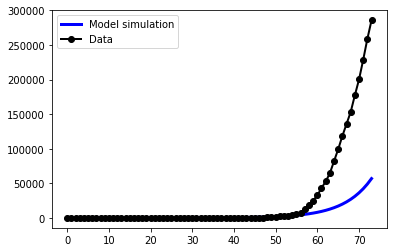

In [6]:
#visualize the result 
plt.plot(times, res[:,1], 'b-', linewidth=3, label='Model simulation')
plt.plot(times, data, 'k-o', linewidth=2, label='Data')
plt.legend()

In [7]:
#define negative log-Likelihood function
def NLL(params, data, times): #negative log likelihood
	params = np.abs(params)
	data = np.array(data)
	res = ode(model, x0fcn(params,data), times, args=(params,))
	y = res[:,1]
	nll = -sum(np.log(norm.pdf(data,y,0.1*np.mean(data))))
	return nll
#find MLE estimator of three parameters 
optimizer = optimize.minimize(NLL, params, args=(data, times), method='Nelder-Mead')
paramests = np.abs(optimizer.x)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [8]:
#resimulate the model 
iniests = x0fcn(paramests, data)
xest = ode(model, iniests, times, args=(paramests,))
est_measure = xest[:,1]

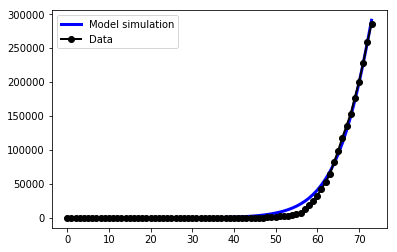

In [9]:
#visualize the resimulate result 
plt.plot(times, est_measure, 'b-', linewidth=3, label='Model simulation')
plt.plot(times, data, 'k-o', linewidth=2, label='Data')
plt.legend()

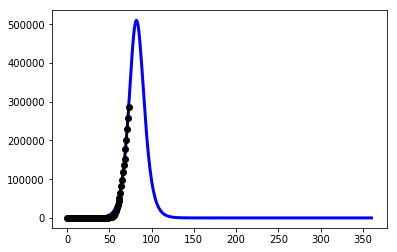

In [10]:
#make prediction for total infection people for a year since the fisrt case in the USA
predict_year=np.linspace(0,360,361)
xest_y = ode(model, iniests, predict_year, args=(paramests,))
plt.plot(predict_year, xest_y[:,1], 'b-', linewidth=3, label='Model simulation')
plt.plot(times, data, 'k-o', linewidth=2, label='Data')